#### У нас есть данные АА-теста с '2023-06-23' по '2023-06-29'. Необходимо провести симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [4]:
import pandas as pd
import numpy as np
import pandahouse
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
# параметры подключения
# наверное, их стоило удалить?..
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [6]:
# для оптимизации заранее посчитаем CTR для каждого пользователя
q = """
SELECT
    exp_group,
    user_id,
    sum(action='like') AS like,
    sum(action='view') AS view,
    like / view AS ctr
FROM simulator_20230720.feed_actions 
WHERE toDate(time) >= '2023-06-23' and toDate(time) <= '2023-06-29'
    AND exp_group IN (2,3)
GROUP BY exp_group, user_id
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,like,view,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [7]:
# для удобства разделим датасет по группам
group_2 = df[df['exp_group'] == 2]
group_3 = df[df['exp_group'] == 3]

# проверим размерность групп
print('Размер группы 2:', group_2.shape[0])
print('Размер группы 3:', group_3.shape[0])

Размер группы 2: 8362
Размер группы 3: 8425


Группы имеют примерно одинаковый размер, что критически важно для интерпритации результатов AA-теста.  
Посмотрим на распределение CTR в группах нативно.

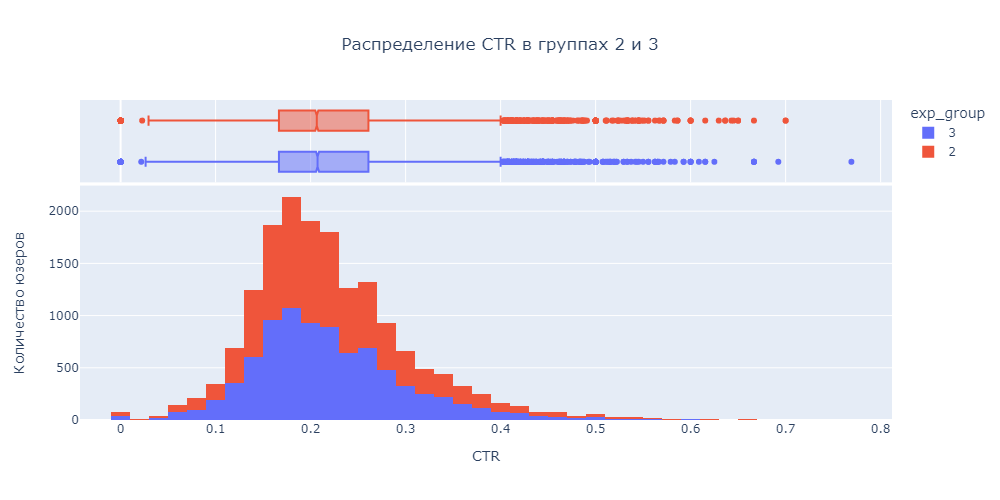

In [14]:
# построим гистограмму распределения ctr в разрезе групп
ctr_hist = px.histogram(
    data_frame=df,
    x='ctr',
    color='exp_group',
    marginal='box',
    width=1000,
    nbins=50,
    title='Распределение CTR в группах 2 и 3'
)

# добавим немного наглядности и выведем график
ctr_hist.update_layout(
    title=dict(x=.5, xanchor='center'),
    yaxis_title='Количество юзеров',
    xaxis_title='CTR')
ctr_hist.show('png')

Графики распределения CTR внешне кажутся максимально идентичными.

In [15]:
# разделим наши группы на 10000 подгрупп по 500 человек в каждой
# поскольку необходимо использовать t-test, исключим повторения пользователей
num_iterations = 10000
sample_size = 500
results = []

for i in range(num_iterations):
    
    # создаем подгруппы для каждой из групп
    sample_2 = group_2.sample(n=sample_size, replace=False)
    sample_3 = group_3.sample(n=sample_size, replace=False)

    # вывполняем t-тест
    t_stat, p_value = ttest_ind(sample_2['ctr'], sample_3['ctr'])

    # сохраним результаты
    results.append(p_value)

**Построим гистограмму распределения получившихся 10000 p-values.**

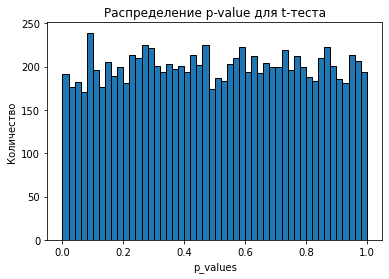

In [17]:
plt.hist(results, bins=50, edgecolor='black')
plt.xlabel('p_values')
plt.ylabel('Количество')
plt.title('Распределение p-value для t-теста');

Распределение кажется довольно равномерным с небольшим перекосом в правую сторону. Близкие к нулю значения p-value не выделяются по сравненнию с другими, а значит, скорее всего, нет статистической значимости в различиях между исследуемыми группами.  
Однако нам в любом случае необходима не только визуальная оценка.

Посчитаем, какой процент p values оказался меньше либо равен 0.05

In [24]:
print(sum(np.array(results) <= 0.05) / len(results) * 100, '%')

4.64 %


**Выводы.**

**1.** Группы примерно равны по размеру.  

**2.** Визуальное распределение p-value довольно равномерное, даже имеет небольшой перекос в правую сторону.  

**3.** Менее 5% значений p-values оказались меньше 0,05.

Таким образом, при уровне значимости в 5% можем считать, что различия между группами не являются статистически значимыми. С учетом этого можем считать работу нашей системы сплитования корректной.

Пожалуй, с учетом целей нашего текущего и будущего исследования, именно такой уровень значимости и стоит оставлять.